In [1]:
!pip install gym

In [ ]:
!apt-get install swig

In [ ]:
# install required system dependencies
!apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
!pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

In [2]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
# from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


In [3]:
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [4]:
def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.9)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)



# plt.figure()
# plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
#            interpolation='none')
# plt.title('Example extracted screen')
# plt.show()

In [5]:
def show_videos():
    mp4list = glob.glob('video/*.mp4')
    mp4list.sort()
    for mp4 in mp4list:
        print(f"\nSHOWING VIDEO {mp4}")
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
    env = Monitor(env, './video', force=True, video_callable=video_callable)
    return env

# Experience replay (Replay Memory)

In [6]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"
    def push(self, state, action, next_state, reward):
        self.memory.append((state,action,next_state,reward))
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples
    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

## Network definition

In [16]:
class DQNCNN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQNCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x))) 
        return self.head(x.view(x.size(0), -1))

### Epsilon-greedy policy


In [17]:
def choose_action_epsilon_greedy(net, state, epsilon):
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')        
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)
    best_action = int(net_out.argmax())
    action_space_dim = net_out.shape[-1]
    if random.random() < epsilon:
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        action = random.choice(non_optimal_actions)
    else:
        action = best_action
    return action, net_out.numpy()

## Crop Funtion
here we defined two funtions 
<b>get_center</b> funtion uses screen pixels and finds the location of the cartpole. It simply iterates over one row of the image and the pixel that represents a black pixel the location(we add 25 to the number as half of width of cartpole).

<b>CroppImage</b> funtion crops the image around the cartpole. the variable **width** defines the width view.


In [35]:
dim = (30, 30)
resize = T.Compose([T.ToPILImage(),T.Resize((30,30)),T.ToTensor()])
def get_center(imgnp):#this function recieves the hole picture of cart_pole and returns it's location  
    temp = 0
    screen_cropped = imgnp[168:301,:,:]
    for i in screen_cropped[131,:,1]:
        if i!= 0:
            temp = temp +1 
        else:
            return temp+25#((temp+30)/600)*4.8*2 - 4.8
    return temp

def CroppImage(sc):
    width = 30
    center = get_center(sc)
    if center >= 570 and center < 600:
        width = 600 - center
    elif center <= 30:
        width = center
    left = center-width
    right = left + 2*width
    if center>= 600:
        width = 70
        right = 600
    try:
        sc_crop = sc[171:290,left :right,:]#left :right
    except:
        print("---------- here is the problem -------------")
    sc_crop = sc_crop.transpose((2, 0, 1))
    sc_crop = torch.from_numpy(sc_crop.copy())
    try:
        sc_crop = resize(sc_crop)
    except:
        print("some problem has been occured")
        print(sc_crop.shape)
    return sc_crop.unsqueeze(0)


Here you can see the output of crop function

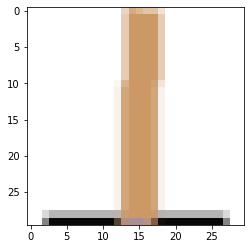

In [36]:
Env = gym.make('CartPole-v0').unwrapped # Initialize the Gym environment
Env.seed(0) # Set a random seed for the environment (reproducible results)
scr = Env.reset()
screen = Env.render(mode='rgb_array')# this is a matrix with 400*600*3 dimension
Env.close()

St= CroppImage(screen)
img = St.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img)

### Softmax policy

In [13]:
def choose_action_softmax(net, state, temperature):
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    with torch.no_grad():
        net.eval()
        net_out = net(state)
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out.squeeze(0)/ temperature, dim=0).numpy()
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

In [14]:
### Define exploration profile
initial_value = 5
num_iterations =  2000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

# Network update

## Update function

In [15]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)
    states = []
    non_final_next_states = []
    non_final_mask = []
    for s in batch:
        states.append(s[0])
        if s[2] is not None:
            non_final_next_states.append(s[2])
            non_final_mask.append(True)
        else:
            non_final_mask.append(False)
    states = torch.cat(states, 0) 
    non_final_next_states = torch.cat(non_final_next_states, 0) 
    non_final_mask = torch.tensor(non_final_mask)#torch.cat(non_final_mask, 0) 
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)
    policy_net.train()
    q_values = policy_net(states)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))
    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) 
    loss = loss_fn(state_action_values, expected_state_action_values)
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

# Training loop 
Reward is not updated

## Training with Learnin Rate = 0.002

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
env = gym.make('CartPole-v1').unwrapped 
env.reset()
img = env.render(mode="rgb_array")
z = np.shape(CroppImage(img).squeeze())#.squeeze()
w = z[1]
h = z[2]
print(w)
print(h)
env.close()
### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 2e-3   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128# Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

30
30


In [ ]:
replay_mem = ReplayMemory(replay_memory_capacity)    
policy_net = DQNCNN(h,w, 2)
target_net = DQNCNN(h,w, 2)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

In [ ]:
env = gym.make('CartPole-v1').unwrapped 
env.seed(0) 
scoreScreen = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):
    env.reset()
    img = env.render(mode="rgb_array")
    last_State = CroppImage(img)
    current_State = CroppImage(img)
    score = 0
    done = False
    while not done:
        state = current_State - last_State
        action, q_values = choose_action_softmax(policy_net, state, temperature=tau)      
        _, reward, done, info = env.step(action)
        last_State = current_State
        Img = env.render(mode="rgb_array")
        current_State = CroppImage(Img)
        try:
            next_state = current_State - last_State
        except:
            print(current_State.shape)
            print(last_State.shape)
            print(Img.shape)
        score += 1
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
        replay_mem.push(state, action, next_state, reward)
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
#         env.render()
        state = next_state
    scoreScreen.append(score)
    if(np.mean(scoreScreen[-50:])>490):
        print("break")
        break
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network
    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.975916619159958
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.951949240166453
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.928097304276156
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.904360255437022
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.880737540275332
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.857228608082783
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.833832910803663
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.81054990302206
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.787379041949158
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.764319787410579
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.741371601833787
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.718533950235563
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.695806300209525
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.6731881219137215
EPISODE: 16 - FINAL SCOR

C:\Users\user\anaconda3\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


EPISODE: 43 - FINAL SCORE: 16 - Temperature: 4.082251749110275
EPISODE: 44 - FINAL SCORE: 15 - Temperature: 4.062588864398525
EPISODE: 45 - FINAL SCORE: 11 - Temperature: 4.043020689434961
EPISODE: 46 - FINAL SCORE: 26 - Temperature: 4.023546768033394
EPISODE: 47 - FINAL SCORE: 29 - Temperature: 4.004166646204941
EPISODE: 48 - FINAL SCORE: 24 - Temperature: 3.984879872147431
EPISODE: 49 - FINAL SCORE: 11 - Temperature: 3.9656859962348823
EPISODE: 50 - FINAL SCORE: 19 - Temperature: 3.946584571007013
Updating target network...
EPISODE: 51 - FINAL SCORE: 10 - Temperature: 3.9275751511588135
EPISODE: 52 - FINAL SCORE: 34 - Temperature: 3.908657293530165
EPISODE: 53 - FINAL SCORE: 14 - Temperature: 3.889830557095506
EPISODE: 54 - FINAL SCORE: 25 - Temperature: 3.8710945029535533
EPISODE: 55 - FINAL SCORE: 14 - Temperature: 3.8524486943170686
EPISODE: 56 - FINAL SCORE: 14 - Temperature: 3.8338926965026765
EPISODE: 57 - FINAL SCORE: 18 - Temperature: 3.8154260769207307
EPISODE: 58 - FINAL SC

EPISODE: 166 - FINAL SCORE: 18 - Temperature: 2.254134635805182
EPISODE: 167 - FINAL SCORE: 45 - Temperature: 2.243277199225417
EPISODE: 168 - FINAL SCORE: 19 - Temperature: 2.232472059401671
EPISODE: 169 - FINAL SCORE: 16 - Temperature: 2.2217189644374065
EPISODE: 170 - FINAL SCORE: 19 - Temperature: 2.211017663649389
Updating target network...
EPISODE: 171 - FINAL SCORE: 12 - Temperature: 2.200367907561843
EPISODE: 172 - FINAL SCORE: 13 - Temperature: 2.1897694479006393
EPISODE: 173 - FINAL SCORE: 38 - Temperature: 2.179222037587503
EPISODE: 174 - FINAL SCORE: 11 - Temperature: 2.168725430734257
EPISODE: 175 - FINAL SCORE: 20 - Temperature: 2.1582793826370854
EPISODE: 176 - FINAL SCORE: 26 - Temperature: 2.1478836497708333
EPISODE: 177 - FINAL SCORE: 26 - Temperature: 2.1375379897833273
EPISODE: 178 - FINAL SCORE: 14 - Temperature: 2.1272421614897254
EPISODE: 179 - FINAL SCORE: 13 - Temperature: 2.1169959248668953
EPISODE: 180 - FINAL SCORE: 45 - Temperature: 2.106799041047818
Updati

EPISODE: 288 - FINAL SCORE: 33 - Temperature: 1.2507106000471035
EPISODE: 289 - FINAL SCORE: 12 - Temperature: 1.2446863321067811
EPISODE: 290 - FINAL SCORE: 17 - Temperature: 1.2386910811142766
Updating target network...
EPISODE: 291 - FINAL SCORE: 15 - Temperature: 1.232724707304349
EPISODE: 292 - FINAL SCORE: 62 - Temperature: 1.226787071584961
EPISODE: 293 - FINAL SCORE: 18 - Temperature: 1.220878035534037
EPISODE: 294 - FINAL SCORE: 19 - Temperature: 1.214997461396235
EPISODE: 295 - FINAL SCORE: 11 - Temperature: 1.2091452120797372
EPISODE: 296 - FINAL SCORE: 64 - Temperature: 1.2033211511530513
EPISODE: 297 - FINAL SCORE: 34 - Temperature: 1.1975251428418319
EPISODE: 298 - FINAL SCORE: 17 - Temperature: 1.1917570520257148
EPISODE: 299 - FINAL SCORE: 17 - Temperature: 1.1860167442351666
EPISODE: 300 - FINAL SCORE: 27 - Temperature: 1.1803040856483502
Updating target network...
EPISODE: 301 - FINAL SCORE: 17 - Temperature: 1.1746189430880047
EPISODE: 302 - FINAL SCORE: 20 - Tempera

EPISODE: 410 - FINAL SCORE: 16 - Temperature: 0.6939589943843006
Updating target network...
EPISODE: 411 - FINAL SCORE: 40 - Temperature: 0.6906164186344748
EPISODE: 412 - FINAL SCORE: 45 - Temperature: 0.6872899429896028
EPISODE: 413 - FINAL SCORE: 28 - Temperature: 0.6839794899006928
EPISODE: 414 - FINAL SCORE: 16 - Temperature: 0.6806849821922817
EPISODE: 415 - FINAL SCORE: 11 - Temperature: 0.6774063430606349
EPISODE: 416 - FINAL SCORE: 14 - Temperature: 0.674143496071957
EPISODE: 417 - FINAL SCORE: 46 - Temperature: 0.6708963651606092
EPISODE: 418 - FINAL SCORE: 40 - Temperature: 0.6676648746273367
EPISODE: 419 - FINAL SCORE: 46 - Temperature: 0.6644489491375029
EPISODE: 420 - FINAL SCORE: 18 - Temperature: 0.661248513719334
Updating target network...
EPISODE: 421 - FINAL SCORE: 41 - Temperature: 0.6580634937621711
EPISODE: 422 - FINAL SCORE: 17 - Temperature: 0.6548938150147305
EPISODE: 423 - FINAL SCORE: 28 - Temperature: 0.651739403583373
EPISODE: 424 - FINAL SCORE: 29 - Temper

Updating target network...
EPISODE: 531 - FINAL SCORE: 36 - Temperature: 0.3869079891571874
EPISODE: 532 - FINAL SCORE: 47 - Temperature: 0.3850443786666019
EPISODE: 533 - FINAL SCORE: 35 - Temperature: 0.3831897445842528
EPISODE: 534 - FINAL SCORE: 68 - Temperature: 0.3813440436736887
EPISODE: 535 - FINAL SCORE: 22 - Temperature: 0.3795072329067137
EPISODE: 536 - FINAL SCORE: 37 - Temperature: 0.37767926946238506
EPISODE: 537 - FINAL SCORE: 18 - Temperature: 0.3758601107260148
EPISODE: 538 - FINAL SCORE: 16 - Temperature: 0.37404971428817574
EPISODE: 539 - FINAL SCORE: 11 - Temperature: 0.37224803794371353
EPISODE: 540 - FINAL SCORE: 17 - Temperature: 0.37045503969076216
Updating target network...
EPISODE: 541 - FINAL SCORE: 20 - Temperature: 0.36867067772976503
EPISODE: 542 - FINAL SCORE: 30 - Temperature: 0.36689491046250067
EPISODE: 543 - FINAL SCORE: 35 - Temperature: 0.3651276964911123
EPISODE: 544 - FINAL SCORE: 43 - Temperature: 0.3633689946171437
EPISODE: 545 - FINAL SCORE: 25

Updating target network...
EPISODE: 651 - FINAL SCORE: 184 - Temperature: 0.21675967734686796
EPISODE: 652 - FINAL SCORE: 394 - Temperature: 0.21571561617480609
EPISODE: 653 - FINAL SCORE: 295 - Temperature: 0.21467658390730965
EPISODE: 654 - FINAL SCORE: 228 - Temperature: 0.21364255632177387
EPISODE: 655 - FINAL SCORE: 115 - Temperature: 0.21261350931226639
EPISODE: 656 - FINAL SCORE: 197 - Temperature: 0.21158941888896532
EPISODE: 657 - FINAL SCORE: 349 - Temperature: 0.21057026117760014
EPISODE: 658 - FINAL SCORE: 277 - Temperature: 0.20955601241889468
EPISODE: 659 - FINAL SCORE: 233 - Temperature: 0.20854664896801373
EPISODE: 660 - FINAL SCORE: 202 - Temperature: 0.20754214729401146
Updating target network...
EPISODE: 661 - FINAL SCORE: 254 - Temperature: 0.20654248397928313
EPISODE: 662 - FINAL SCORE: 201 - Temperature: 0.20554763571901885
EPISODE: 663 - FINAL SCORE: 253 - Temperature: 0.20455757932066057
EPISODE: 664 - FINAL SCORE: 242 - Temperature: 0.20357229170336125
EPISODE:

EPISODE: 769 - FINAL SCORE: 204 - Temperature: 0.12261486218660438
EPISODE: 770 - FINAL SCORE: 158 - Temperature: 0.12202426610206653
Updating target network...
EPISODE: 771 - FINAL SCORE: 171 - Temperature: 0.12143651472761398
EPISODE: 772 - FINAL SCORE: 235 - Temperature: 0.1208515943611995
EPISODE: 773 - FINAL SCORE: 209 - Temperature: 0.12026949136677408
EPISODE: 774 - FINAL SCORE: 191 - Temperature: 0.11969019217396924
EPISODE: 775 - FINAL SCORE: 197 - Temperature: 0.11911368327778053
EPISODE: 776 - FINAL SCORE: 176 - Temperature: 0.11853995123825276
EPISODE: 777 - FINAL SCORE: 242 - Temperature: 0.11796898268016658
EPISODE: 778 - FINAL SCORE: 204 - Temperature: 0.11740076429272682
EPISODE: 779 - FINAL SCORE: 214 - Temperature: 0.11683528282925208
EPISODE: 780 - FINAL SCORE: 185 - Temperature: 0.11627252510686589
Updating target network...
EPISODE: 781 - FINAL SCORE: 170 - Temperature: 0.1157124780061895
EPISODE: 782 - FINAL SCORE: 176 - Temperature: 0.11515512847103589
EPISODE: 7

EPISODE: 887 - FINAL SCORE: 240 - Temperature: 0.06935978413079706
EPISODE: 888 - FINAL SCORE: 182 - Temperature: 0.06902570051155606
EPISODE: 889 - FINAL SCORE: 188 - Temperature: 0.06869322606492195
EPISODE: 890 - FINAL SCORE: 181 - Temperature: 0.06836235304003142
Updating target network...
EPISODE: 891 - FINAL SCORE: 219 - Temperature: 0.06803307372335453
EPISODE: 892 - FINAL SCORE: 173 - Temperature: 0.06770538043851489
EPISODE: 893 - FINAL SCORE: 195 - Temperature: 0.06737926554611076
EPISODE: 894 - FINAL SCORE: 161 - Temperature: 0.06705472144353689
EPISODE: 895 - FINAL SCORE: 189 - Temperature: 0.06673174056480737
EPISODE: 896 - FINAL SCORE: 212 - Temperature: 0.06641031538037914
EPISODE: 897 - FINAL SCORE: 192 - Temperature: 0.06609043839697655
EPISODE: 898 - FINAL SCORE: 211 - Temperature: 0.06577210215741659
EPISODE: 899 - FINAL SCORE: 167 - Temperature: 0.06545529924043515
EPISODE: 900 - FINAL SCORE: 68 - Temperature: 0.0651400222605139
Updating target network...
EPISODE: 9

EPISODE: 1005 - FINAL SCORE: 182 - Temperature: 0.039234882043494596
EPISODE: 1006 - FINAL SCORE: 186 - Temperature: 0.03904590032220107
EPISODE: 1007 - FINAL SCORE: 290 - Temperature: 0.0388578288646607
EPISODE: 1008 - FINAL SCORE: 244 - Temperature: 0.03867066328642774
EPISODE: 1009 - FINAL SCORE: 180 - Temperature: 0.038484399224174924
EPISODE: 1010 - FINAL SCORE: 169 - Temperature: 0.03829903233559172
Updating target network...
EPISODE: 1011 - FINAL SCORE: 182 - Temperature: 0.03811455829928309
EPISODE: 1012 - FINAL SCORE: 208 - Temperature: 0.03793097281466877
EPISODE: 1013 - FINAL SCORE: 181 - Temperature: 0.037748271601882974
EPISODE: 1014 - FINAL SCORE: 172 - Temperature: 0.03756645040167468
EPISODE: 1015 - FINAL SCORE: 171 - Temperature: 0.037385504975308265
EPISODE: 1016 - FINAL SCORE: 174 - Temperature: 0.03720543110446474
EPISODE: 1017 - FINAL SCORE: 197 - Temperature: 0.03702622459114338
EPISODE: 1018 - FINAL SCORE: 191 - Temperature: 0.0368478812575639
EPISODE: 1019 - FIN

Updating target network...
EPISODE: 1121 - FINAL SCORE: 174 - Temperature: 0.02240942895172911
EPISODE: 1122 - FINAL SCORE: 154 - Temperature: 0.02230148998935864
EPISODE: 1123 - FINAL SCORE: 212 - Temperature: 0.022194070934015816
EPISODE: 1124 - FINAL SCORE: 185 - Temperature: 0.02208716928147686
EPISODE: 1125 - FINAL SCORE: 179 - Temperature: 0.02198078253958
EPISODE: 1126 - FINAL SCORE: 172 - Temperature: 0.021874908228167428
EPISODE: 1127 - FINAL SCORE: 186 - Temperature: 0.021769543879027443
EPISODE: 1128 - FINAL SCORE: 184 - Temperature: 0.021664687035836922
EPISODE: 1129 - FINAL SCORE: 184 - Temperature: 0.021560335254104043
EPISODE: 1130 - FINAL SCORE: 163 - Temperature: 0.02145648610111133
Updating target network...
EPISODE: 1131 - FINAL SCORE: 160 - Temperature: 0.021353137155858903
EPISODE: 1132 - FINAL SCORE: 193 - Temperature: 0.021250286009008062
EPISODE: 1133 - FINAL SCORE: 166 - Temperature: 0.02114793026282511
EPISODE: 1134 - FINAL SCORE: 236 - Temperature: 0.02104606

KeyboardInterrupt: 

In [ ]:
env.close()

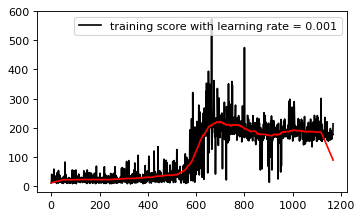

In [ ]:
n = 100
shifted = []
rc = np.convolve(np.ones(n),scoreScreen)
for i,r in enumerate(rc):
    if i>= n/2:
        shifted.append(r/n)
    if i + n/2 == len(rc):
        break
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(scoreScreen,c = 'k',label='training score with learning rate = 0.001')
plt.plot(shifted, c = 'r')
plt.legend()

## Training with Learning Rate = 0.001
In this part we set the learning rate to 0.001 and in the training loop we break if last 30 trials have scores larger than 490

In [25]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
env = gym.make('CartPole-v1').unwrapped 
env.reset()
img = env.render(mode="rgb_array")
z = np.shape(CroppImage(img).squeeze())#.squeeze()
w = z[1]
h = z[2]
print(w)
print(h)
env.close()
### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-3   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128# Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

30
30


In [34]:
replay_mem = ReplayMemory(replay_memory_capacity)    
path = 'savedModelScreen.pth'

policy_net2 = DQNCNN(h,w, 2)
# policy_net.load_state_dict(torch.load(path))
target_net2 = DQNCNN(h,w, 2)
target_net2.load_state_dict(policy_net2.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.SGD(policy_net2.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

In [ ]:
env = gym.make('CartPole-v1').unwrapped 
env.seed(0) 
scoreScreen2 = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):
    env.reset()
    img = env.render(mode="rgb_array")
    last_State = CroppImage(img)
    current_State = CroppImage(img)
    score = 0
    done = False

    while not done:

        state = current_State - last_State
        action, q_values = choose_action_softmax(policy_net2, state, temperature=tau)      
        _, reward, done, info = env.step(action)
        last_State = current_State
        Img = env.render(mode="rgb_array")
        current_State = CroppImage(Img)
        next_state = current_State - last_State
        score += 1
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None

      # Update the replay memory
        replay_mem.push(state, action, next_state, reward)

      # Update the network
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net2, target_net2, replay_mem, gamma, optimizer, loss_fn, batch_size)
#         env.render()
        state = next_state
    scoreScreen2.append(score)
    if( len(scoreScreen2)%51 == 0):
        print("--------------------------------------------------------")
        print(f"mean of last 50 Trials : {np.mean(scoreScreen2[-50:])}")
        print("--------------------------------------------------------")
    if(np.mean(scoreScreen2[-30:])>490):
        print("break")
        break
    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net2.load_state_dict(policy_net2.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 29 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 28 - Temperature: 4.975916619159958
EPISODE: 3 - FINAL SCORE: 27 - Temperature: 4.951949240166453
EPISODE: 4 - FINAL SCORE: 40 - Temperature: 4.928097304276156
EPISODE: 5 - FINAL SCORE: 25 - Temperature: 4.904360255437022
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.880737540275332
EPISODE: 7 - FINAL SCORE: 18 - Temperature: 4.857228608082783
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.833832910803663
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 4.81054990302206
EPISODE: 10 - FINAL SCORE: 58 - Temperature: 4.787379041949158
Updating target network...
EPISODE: 11 - FINAL SCORE: 28 - Temperature: 4.764319787410579
EPISODE: 12 - FINAL SCORE: 20 - Temperature: 4.741371601833787
EPISODE: 13 - FINAL SCORE: 18 - Temperature: 4.718533950235563
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 4.695806300209525
EPISODE: 15 - FINAL SCORE: 28 - Temperature: 4.6731881219137215
EPISODE: 16 - FINAL SCOR

Updating target network...
EPISODE: 121 - FINAL SCORE: 38 - Temperature: 2.8011786189662518
EPISODE: 122 - FINAL SCORE: 79 - Temperature: 2.7876862486699427
EPISODE: 123 - FINAL SCORE: 15 - Temperature: 2.7742588667520893
EPISODE: 124 - FINAL SCORE: 9 - Temperature: 2.7608961601847186
EPISODE: 125 - FINAL SCORE: 39 - Temperature: 2.747597817447611
EPISODE: 126 - FINAL SCORE: 22 - Temperature: 2.7343635285210386
EPISODE: 127 - FINAL SCORE: 23 - Temperature: 2.7211929848785403
EPISODE: 128 - FINAL SCORE: 17 - Temperature: 2.7080858794797242
EPISODE: 129 - FINAL SCORE: 10 - Temperature: 2.695041906763114
EPISODE: 130 - FINAL SCORE: 28 - Temperature: 2.6820607626390243
Updating target network...
EPISODE: 131 - FINAL SCORE: 40 - Temperature: 2.6691421444824703
EPISODE: 132 - FINAL SCORE: 17 - Temperature: 2.656285751126115
EPISODE: 133 - FINAL SCORE: 11 - Temperature: 2.6434912828532453
EPISODE: 134 - FINAL SCORE: 21 - Temperature: 2.630758441390788
EPISODE: 135 - FINAL SCORE: 12 - Temperat

EPISODE: 239 - FINAL SCORE: 25 - Temperature: 1.5845480789075952
EPISODE: 240 - FINAL SCORE: 25 - Temperature: 1.5769158239388577
Updating target network...
EPISODE: 241 - FINAL SCORE: 18 - Temperature: 1.5693203310707358
EPISODE: 242 - FINAL SCORE: 55 - Temperature: 1.5617614232320964
EPISODE: 243 - FINAL SCORE: 32 - Temperature: 1.5542389242046994
EPISODE: 244 - FINAL SCORE: 13 - Temperature: 1.5467526586190916
EPISODE: 245 - FINAL SCORE: 36 - Temperature: 1.5393024519505174
EPISODE: 246 - FINAL SCORE: 22 - Temperature: 1.5318881305148504
EPISODE: 247 - FINAL SCORE: 12 - Temperature: 1.5245095214645445
EPISODE: 248 - FINAL SCORE: 20 - Temperature: 1.5171664527846043
EPISODE: 249 - FINAL SCORE: 31 - Temperature: 1.509858753288575
EPISODE: 250 - FINAL SCORE: 12 - Temperature: 1.502586252614551
Updating target network...
EPISODE: 251 - FINAL SCORE: 26 - Temperature: 1.4953487812212054
EPISODE: 252 - FINAL SCORE: 19 - Temperature: 1.488146170383837
EPISODE: 253 - FINAL SCORE: 46 - Temper

--------------------------------------------------------
mean of last 50 Trials : 24.34
--------------------------------------------------------
EPISODE: 357 - FINAL SCORE: 24 - Temperature: 0.8963343491806082
EPISODE: 358 - FINAL SCORE: 39 - Temperature: 0.8920169968823426
EPISODE: 359 - FINAL SCORE: 11 - Temperature: 0.8877204398720011
EPISODE: 360 - FINAL SCORE: 20 - Temperature: 0.8834445779854156
Updating target network...
EPISODE: 361 - FINAL SCORE: 10 - Temperature: 0.8791893115408771
EPISODE: 362 - FINAL SCORE: 27 - Temperature: 0.8749545413368104
EPISODE: 363 - FINAL SCORE: 15 - Temperature: 0.8707401686494626
EPISODE: 364 - FINAL SCORE: 65 - Temperature: 0.8665460952306012
EPISODE: 365 - FINAL SCORE: 12 - Temperature: 0.8623722233052232
EPISODE: 366 - FINAL SCORE: 35 - Temperature: 0.8582184555692765
EPISODE: 367 - FINAL SCORE: 15 - Temperature: 0.8540846951873909
EPISODE: 368 - FINAL SCORE: 12 - Temperature: 0.8499708457906212
EPISODE: 369 - FINAL SCORE: 47 - Temperature: 0.

Exception ignored in: <function Viewer.__del__ at 0x000002319D7E6CA0>
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "C:\Users\user\anaconda3\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "C:\Users\user\anaconda3\lib\site-packages\pyglet\window\win32\__init__.py", line 328, in close
    super(Win32Window, self).close()
  File "C:\Users\user\anaconda3\lib\site-packages\pyglet\window\__init__.py", line 857, in close
    app.windows.remove(self)
  File "C:\Users\user\anaconda3\lib\_weakrefset.py", line 114, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x00000231C136C2C0; to 'Win32Window' at 0x00000231AC424C70>


EPISODE: 448 - FINAL SCORE: 58 - Temperature: 0.5776319787061974
EPISODE: 449 - FINAL SCORE: 29 - Temperature: 0.5748497125204837
EPISODE: 450 - FINAL SCORE: 30 - Temperature: 0.5720808476099998
Updating target network...
EPISODE: 451 - FINAL SCORE: 40 - Temperature: 0.5693253194251426
EPISODE: 452 - FINAL SCORE: 11 - Temperature: 0.5665830637272238
EPISODE: 453 - FINAL SCORE: 35 - Temperature: 0.5638540165869717
EPISODE: 454 - FINAL SCORE: 23 - Temperature: 0.5611381143830414
EPISODE: 455 - FINAL SCORE: 12 - Temperature: 0.5584352938005315
EPISODE: 456 - FINAL SCORE: 24 - Temperature: 0.5557454918295077
EPISODE: 457 - FINAL SCORE: 19 - Temperature: 0.5530686457635343
EPISODE: 458 - FINAL SCORE: 15 - Temperature: 0.5504046931982125
--------------------------------------------------------
mean of last 50 Trials : 27.74
--------------------------------------------------------
EPISODE: 459 - FINAL SCORE: 37 - Temperature: 0.5477535720297246
EPISODE: 460 - FINAL SCORE: 99 - Temperature: 0.

EPISODE: 562 - FINAL SCORE: 17 - Temperature: 0.3331221317626301
EPISODE: 563 - FINAL SCORE: 31 - Temperature: 0.3315175903295329
EPISODE: 564 - FINAL SCORE: 79 - Temperature: 0.32992077745291704
EPISODE: 565 - FINAL SCORE: 37 - Temperature: 0.3283316559068288
EPISODE: 566 - FINAL SCORE: 82 - Temperature: 0.3267501886446196
EPISODE: 567 - FINAL SCORE: 25 - Temperature: 0.32517633879808283
EPISODE: 568 - FINAL SCORE: 28 - Temperature: 0.3236100696765939
EPISODE: 569 - FINAL SCORE: 57 - Temperature: 0.3220513447662551
EPISODE: 570 - FINAL SCORE: 39 - Temperature: 0.32050012772904446
Updating target network...
EPISODE: 571 - FINAL SCORE: 57 - Temperature: 0.3189563824019682
EPISODE: 572 - FINAL SCORE: 35 - Temperature: 0.31742007279621853
EPISODE: 573 - FINAL SCORE: 65 - Temperature: 0.31589116309633347
EPISODE: 574 - FINAL SCORE: 41 - Temperature: 0.31436961765936294
EPISODE: 575 - FINAL SCORE: 61 - Temperature: 0.3128554010140372
EPISODE: 576 - FINAL SCORE: 45 - Temperature: 0.311348477

EPISODE: 678 - FINAL SCORE: 69 - Temperature: 0.1902663231077806
EPISODE: 679 - FINAL SCORE: 56 - Temperature: 0.18934987184369279
EPISODE: 680 - FINAL SCORE: 23 - Temperature: 0.18843783482856782
Updating target network...
EPISODE: 681 - FINAL SCORE: 92 - Temperature: 0.18753019080039796
EPISODE: 682 - FINAL SCORE: 131 - Temperature: 0.18662691859958758
EPISODE: 683 - FINAL SCORE: 166 - Temperature: 0.18572799716846014
EPISODE: 684 - FINAL SCORE: 258 - Temperature: 0.18483340555076688
EPISODE: 685 - FINAL SCORE: 24 - Temperature: 0.18394312289119866
EPISODE: 686 - FINAL SCORE: 204 - Temperature: 0.1830571284348996
EPISODE: 687 - FINAL SCORE: 150 - Temperature: 0.18217540152698317
EPISODE: 688 - FINAL SCORE: 150 - Temperature: 0.18129792161205077
EPISODE: 689 - FINAL SCORE: 17 - Temperature: 0.18042466823371253
EPISODE: 690 - FINAL SCORE: 115 - Temperature: 0.1795556210341104
Updating target network...
EPISODE: 691 - FINAL SCORE: 142 - Temperature: 0.17869075975344345
EPISODE: 692 - FI

EPISODE: 792 - FINAL SCORE: 961 - Temperature: 0.10972717143927273
EPISODE: 793 - FINAL SCORE: 288 - Temperature: 0.1091986511876182
EPISODE: 794 - FINAL SCORE: 148 - Temperature: 0.10867267664686414
EPISODE: 795 - FINAL SCORE: 283 - Temperature: 0.1081492355551455
EPISODE: 796 - FINAL SCORE: 44 - Temperature: 0.10762831570965871
EPISODE: 797 - FINAL SCORE: 219 - Temperature: 0.10710990496637712
EPISODE: 798 - FINAL SCORE: 279 - Temperature: 0.10659399123976793
EPISODE: 799 - FINAL SCORE: 391 - Temperature: 0.10608056250251044
EPISODE: 800 - FINAL SCORE: 732 - Temperature: 0.10556960678521565
Updating target network...
EPISODE: 801 - FINAL SCORE: 92 - Temperature: 0.1050611121761473
EPISODE: 802 - FINAL SCORE: 54 - Temperature: 0.10455506682094398
EPISODE: 803 - FINAL SCORE: 127 - Temperature: 0.10405145892234302
EPISODE: 804 - FINAL SCORE: 61 - Temperature: 0.10355027673990526
EPISODE: 805 - FINAL SCORE: 295 - Temperature: 0.10305150858974149
EPISODE: 806 - FINAL SCORE: 395 - Temperat

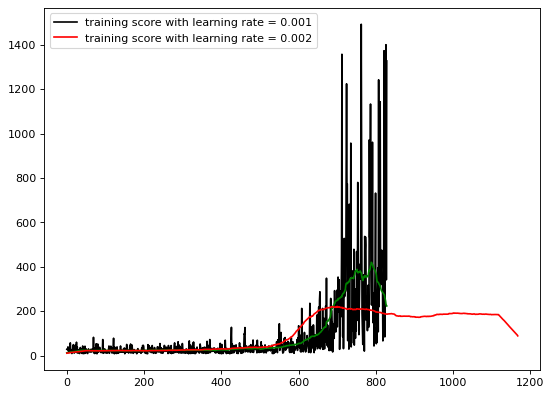

In [ ]:
n = 80
shifted2 = []
# shifted2 = []
rc = np.convolve(np.ones(n),scoreScreen2)
# rc2 = np.convolve(np.ones(n),learningRate01)
for i,r in enumerate(rc):
    if i>= n/2:
        shifted2.append(r/n)
    if i + n/2 == len(rc):
        break
# for i,r in enumerate(rc2):
#     if i>= n/2:
#         shifted2.append(r/n)
#     if i + n/2 == len(rc2):
#         break
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(scoreScreen2,c = 'k',label='training score with learning rate = 0.001')
# plt.plot(rc/n)
plt.plot(shifted2, c = 'g')
plt.plot(shifted, c = 'r',label='training score with learning rate = 0.002')
# plt.plot(learningRate01, c = 'g',label='training score with learning rate = 0.01')
plt.legend()

In [ ]:
# path = 'savedModelScreen.pth'
# torch.save(policy_net2.state_dict(), path)

# **New method** 
in this part we did some more preprocessing to the screen.
since the color of the images seem not to be so important  we changed the images to gray and then using canny edge detector we turned the images to binary images. then for training the network we merged three زonsecutive frames of the environment into one frame and the used it as state of the environment. 

In [19]:
import cv2 as cv

In [20]:

def CroppImage2(sc):
    width = 70
    location = get_center(sc)# this is cartpole location
    left = location - width/2
    right = location + width/2
    if max(0,location - width/2) == 0:
        left = 0
        right = width
    elif min(600,location + width/2) ==600:
        left = 600 - width
        right = 600
    sc_crop = sc[171:290,int(left) :int(right),:]
    return sc_crop,location

def CroppImage3(sc):
    width = 30
    center = get_center(sc)
    if center >= 570 and center < 600:
        width = 600 - center
    elif center <= 30:
        width = center
    left = center-width
    right = left + 2*width
    if center>= 600:
        width = 70
        right = 600
    sc_crop = sc[171:290,left :right,:]#left :right

    return sc_crop,center
def EdgeImg(img):
    gray = cv.cvtColor(CroppImage3(img)[0], cv.COLOR_BGR2GRAY)
    cannyImg = cv.Canny(gray,10,100)
    cannyImg = cv.resize(cannyImg, dim, interpolation = cv.INTER_AREA)
    return cannyImg

# this funtion just change the format of the image in a proper way to feed to network
def makeReady(merged):
    sc_crop = merged.transpose((2, 0, 1))
    sc_crop = torch.from_numpy(sc_crop.copy())
    sc_crop = resize(sc_crop)
    sc_crop = sc_crop.unsqueeze(0)
    return sc_crop

Here you can see the output of out preprocessing step

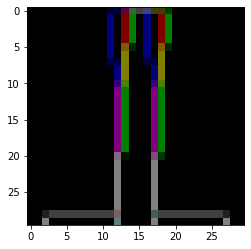

In [21]:
Env = gym.make('CartPole-v0').unwrapped # Initialize the Gym environment
Env.seed(0) # Set a random seed for the environment (reproducible results)
scr = Env.reset()
screen = Env.render(mode='rgb_array')# this is a matrix with 400*600*3 dimension
for i in range(10):
  action = random.choice([0, 1])
  Env.step(action)
Next_state = Env.render(mode="rgb_array")
for i in range(10):
  action = random.choice([0, 1])
  Env.step(action)
Next_state3 = Env.render(mode="rgb_array")

cannyImg = EdgeImg(screen)
cannyImgNext =  EdgeImg(Next_state)
cannyImgNext3 =  EdgeImg(Next_state3)
# sum = cannyImg + cannyImgNext
merged = cv.merge([cannyImg, cannyImgNext, cannyImgNext3])
Env.close()

# St,_ = CroppImage2(screen)
# print(St.squeeze().shape)
St = makeReady(merged)
img = St.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(img)

# plt.imshow(sum, cmap='gray')
# slice1Copy = np.uint8(img)
# canImg = cv.Canny(slice1Copy,100,200)
# plt.imshow(slice1Copy)

In [23]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
env = gym.make('CartPole-v1').unwrapped 
env.reset()
img = env.render(mode="rgb_array")
z = np.shape(CroppImage(img).squeeze())#.squeeze()
w = z[1]
h = z[2]
print(w)
print(h)
env.close()
### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 2e-3   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128# Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

30
30


In [24]:
replay_mem = ReplayMemory(replay_memory_capacity)    
path = 'savedModelScreen.pth'

policy_net2 = DQNCNN(h,w, 2)
# policy_net.load_state_dict(torch.load(path))
target_net2 = DQNCNN(h,w, 2)
target_net2.load_state_dict(policy_net2.state_dict()) # This will copy the weights of the policy network to the target network

optimizer = torch.optim.SGD(policy_net2.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
loss_fn = nn.SmoothL1Loss()

In [25]:
env = gym.make('CartPole-v1').unwrapped 
env.seed(0)
scoreScreen2 = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):
    env.reset()
    img = env.render(mode="rgb_array")
    score = 0
    done = False
    first = EdgeImg(img)
    second = EdgeImg(img)
    third = EdgeImg(img)
    merged = cv.merge([first,second,third])
    state = makeReady(merged)
    while not done:
        action, q_values = choose_action_softmax(policy_net2, state, temperature=tau)      
        _, reward, done, info = env.step(action)
        Img = env.render(mode="rgb_array")
        first = second
        second = third
        third = EdgeImg(Img)
        merged = cv.merge([first,second,third])
        next_state = makeReady(merged)
        score += 1
        if done: # if the pole has fallen down 
            reward += bad_state_penalty
            next_state = None
        replay_mem.push(state, action, next_state, reward)
        if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
            update_step(policy_net2, target_net2, replay_mem, gamma, optimizer, loss_fn, batch_size)
        state = next_state
    scoreScreen2.append(score)
    if( len(scoreScreen2) % 51 == 0):
        print("--------------------------------------------------------")
        print(f"mean of last 50 Trials : {np.mean(scoreScreen2[-50:])}")
        print("--------------------------------------------------------")
    if(np.mean(scoreScreen2[-30:])>490):
        print("break")
        break
    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net2.load_state_dict(policy_net2.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.975916619159958
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.951949240166453
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.928097304276156
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.904360255437022
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.880737540275332
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.857228608082783
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.833832910803663
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.81054990302206
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.787379041949158
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.764319787410579
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.741371601833787
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.718533950235563
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.695806300209525
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.6731881219137215
EPISODE: 16 - FINAL SCOR

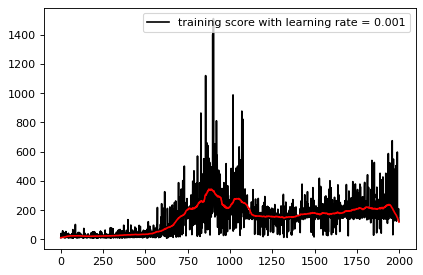

In [34]:
n = 100
shifted = []
# shifted2 = []
rc = np.convolve(np.ones(n),scoreScreen2)
# rc2 = np.convolve(np.ones(n),learningRate01)
for i,r in enumerate(rc):
    if i>= n/2:
        shifted.append(r/n)
    if i + n/2 == len(rc):
        break
# for i,r in enumerate(rc2):
#     if i>= n/2:
#         shifted2.append(r/n)
#     if i + n/2 == len(rc2):
#         break
plt.figure(figsize=(6,4), dpi=80)
plt.plot(scoreScreen2,c = 'k',label='training score with learning rate = 0.001')
# plt.plot(rc/n)
plt.plot(shifted, c = 'r')
# plt.plot(learningRate01, c = 'g',label='training score with learning rate = 0.01')
plt.legend()

# Final test

In [26]:
path = 'savedModelScreen.pth'
h=30
w=30
policy_net = DQNCNN(h,w, 2)
policy_net.load_state_dict(torch.load(path))
target_net = DQNCNN(h,w, 2)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [31]:
env = gym.make('CartPole-v1') 
env.seed(1) 
env = wrap_env(env, video_callable=lambda episode_id: True)
scores = []
for num_episode in range(10): 
    env.reset()
    img = env.render(mode="rgb_array")
    last_State = CroppImage(img)
    current_State = CroppImage(img)
    score = 0
    done = False
    while not done:
        state = current_State - last_State 
        last_State = current_State
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        _, reward, done, info = env.step(action)
        img = env.render(mode="rgb_array")
        current_State= CroppImage(img)
        score += reward 
    scores.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {scores[-1]}") 
print(f"-----------------------------------------------------------") 
print(f"MEAN OF {num_episode + 1} - FINAL SCORE: {np.mean(scores)}") 
print(f"-----------------------------------------------------------") 
env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 1 - FINAL SCORE: 334.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 2 - FINAL SCORE: 500.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 3 - FINAL SCORE: 500.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 4 - FINAL SCORE: 350.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 5 - FINAL SCORE: 500.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 6 - FINAL SCORE: 406.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 7 - FINAL SCORE: 500.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 8 - FINAL SCORE: 315.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 9 - FINAL SCORE: 452.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


EPISODE 10 - FINAL SCORE: 500.0
-----------------------------------------------------------
MEAN OF 10 - FINAL SCORE: 435.7
-----------------------------------------------------------


In [32]:
show_videos()


SHOWING VIDEO video/openaigym.video.3.2987.video000000.mp4



SHOWING VIDEO video/openaigym.video.3.2987.video000001.mp4



SHOWING VIDEO video/openaigym.video.3.2987.video000002.mp4



SHOWING VIDEO video/openaigym.video.3.2987.video000003.mp4



SHOWING VIDEO video/openaigym.video.3.2987.video000004.mp4



SHOWING VIDEO video/openaigym.video.3.2987.video000005.mp4



SHOWING VIDEO video/openaigym.video.3.2987.video000006.mp4



SHOWING VIDEO video/openaigym.video.3.2987.video000007.mp4



SHOWING VIDEO video/openaigym.video.3.2987.video000008.mp4



SHOWING VIDEO video/openaigym.video.3.2987.video000009.mp4
